In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.nn.functional import relu
from scipy.io import loadmat
import os
from os import listdir
import pandas as pd
from skimage import io
from PIL import Image

In [2]:
moving_files = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/move/'+f).shape[2] == 100:
        moving_files.append(f)
        
sleeping_files = []
for f in os.listdir('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'):
    if np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/sleep/'+f).shape[2] == 100:
        sleeping_files.append(f)

In [3]:
import random
diff = len(sleeping_files)-len(moving_files)
i = 0
while i < diff:
    ind = random.randint(1,len(moving_files)-1)
    x = moving_files[ind]
    if ('0326' not in x) and ('0328' not in x):
        moving_files.append(x)
        i += 1

In [4]:
len(moving_files), len(sleeping_files)

(17148, 17148)

In [5]:
m, s = 0, 0
for ind in range(len(moving_files)):
    x,y = moving_files[ind], sleeping_files[ind]
    if ('0326' not in x) and ('0328' not in x):
        m += 1
    if ('0326' not in y) and ('0328' not in y):
        s += 1

In [6]:
m,s

(17104, 14325)

In [18]:
class NoahSpectrogramDataset(Dataset):
    def __init__(self, mode='train' ,moving_files=moving_files,sleeping_files=sleeping_files):
        self.movement_files = moving_files
        self.sleeping_files = sleeping_files
        all_files = self.sleeping_files + self.movement_files
        if mode == 'train':
            self.all_files = [f for f in all_files if '0326' not in f if '0328' not in f]
        elif mode == 'valid':
            self.all_files = [f for f in all_files if '0326' in f]
        elif mode == 'test':
            self.all_files = [f for f in all_files if '0328' in f]
            
    def __len__(self):
        return len(self.all_files)
    
    def __getitem__(self, idx):
        mvmt_type  = self.all_files[idx].split('_')[-1].split('.')[0]
        spec = torch.from_numpy(np.load('/mnt/pesaranlab/People/Capstone_students/Noah/data/'+ mvmt_type +'/' +self.all_files[idx])) 
        if mvmt_type == 'move':
            label = torch.Tensor([0])
        elif mvmt_type == 'sleep':
            label = torch.Tensor([1])
        else:
            label = torch.Tensor([-1])
        return  spec.resize(spec.shape[0],100,10), label

In [19]:
train_dataset = NoahSpectrogramDataset(mode='train')
valid_dataset = NoahSpectrogramDataset(mode='valid')
test_dataset  = NoahSpectrogramDataset(mode='test')

In [20]:
len(test_dataset)

0

In [9]:
train_loader = DataLoader(dataset = train_dataset, batch_size = 32, shuffle = True)
val_loader = DataLoader(dataset = valid_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(dataset = test_dataset, batch_size = 32, shuffle = False)

In [17]:
len(test_loader)

0

In [10]:
for batch_idx, (data, labels) in enumerate(train_loader):
    print(data.shape)
    print(data.reshape([data.shape[0],1,-1]).shape)
    print(labels.shape)
    break

/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/tensor.py:358: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


torch.Size([32, 62, 100, 10])
torch.Size([32, 1, 62000])
torch.Size([32, 1])


## Train and test functions

In [11]:
def train(loader):
    model.train()
    batch_losses = []
    
    correct = 0
    total = 0
    
    for batch_idx, (data, labels) in enumerate(loader):
        data = data.to(device)
        labels = labels.to(device).float()
        
        if (torch.isinf(data).any()) or (torch.isnan(data).any()):
            continue
        
        output = model(data)
        loss = criterion(output.reshape(output.shape[0],-1), labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_losses.append(loss)
        
        predictions = []
        for o in output:
            if o.item() > .5:
                predictions.append(1)
            else:
                predictions.append(0)
        predictions = np.array(predictions)
        total += labels.size(0)
        correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
        
    
    epoch_loss = sum(batch_losses)/len(batch_losses)
    accuracy = correct / total
    
    return(epoch_loss, accuracy)

In [12]:
def test(loader):
    model.eval()
    batch_losses = []
    
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device)
            labels = labels.to(device).float().flatten()
            
            if (torch.isinf(data).any()) or (torch.isnan(data).any()):
                continue
            
            output = model(data)
            loss = criterion(output, labels)
            
            batch_losses.append(loss)
            
            #get accuracy
            predictions = []
            for o in output:
                if o.item() > .5:
                    predictions.append(1)
                else:
                    predictions.append(0)
            predictions = np.array(predictions)
            total += labels.size(0)
            correct += (predictions.flatten() == labels.flatten().cpu().numpy()).sum().item()
        
        epoch_loss = sum(batch_losses)/len(batch_losses)
        accuracy = correct/total
        
        return epoch_loss, accuracy

In [13]:
class LogReg(nn.Module):
    def __init__(self, num_classes = 1):
        super(LogReg, self).__init__()
        self.fc1 = nn.Linear(100*10*62, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], 1, 100*10*62)
        x = self.fc1(x)
        x = self.sigmoid(x)
        return x

In [14]:
input_size = 1000 #(10x100)
num_classes = 1
learning_rate = 0.0005
num_epochs = 10

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [13]:
model = LogReg().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


epochs = []
training_losses = []
val_losses = []
training_acc = []
val_acc = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

Train loss for epoch 0: 1.185036063194275


/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)
/home/bijanadmin/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Val loss for epoch 0: 2.1118462085723877
Train loss for epoch 1: 1.146826148033142
Val loss for epoch 1: 1.7659541368484497
Train loss for epoch 2: 1.2342395782470703
Val loss for epoch 2: 1.2367976903915405
Train loss for epoch 3: 0.9290778040885925
Val loss for epoch 3: 2.3812167644500732
Train loss for epoch 4: 1.0764780044555664
Val loss for epoch 4: 1.5056226253509521
Train loss for epoch 5: 0.8283095359802246
Val loss for epoch 5: 2.221039295196533
Train loss for epoch 6: 0.874661922454834
Val loss for epoch 6: 1.7693417072296143
Train loss for epoch 7: 0.8483171463012695
Val loss for epoch 7: 0.9321001172065735
Train loss for epoch 8: 0.9070748686790466
Val loss for epoch 8: 2.3408305644989014
Train loss for epoch 9: 0.8035086989402771
Val loss for epoch 9: 1.5409234762191772


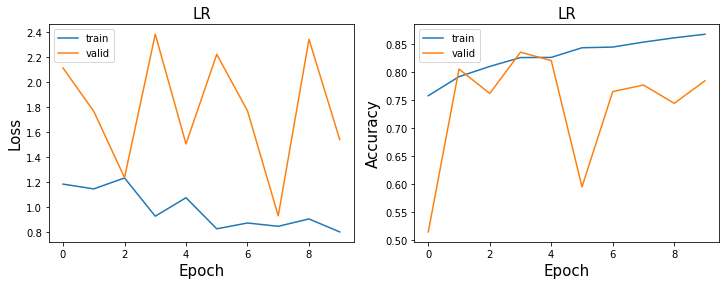

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("LR", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("LR", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(val_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

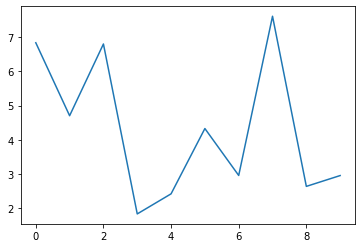

In [15]:
plt.plot(val_losses)

In [15]:
class MLP(nn.Module):
    def __init__(self, num_classes = 1):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(100*10*62, 1000)
        self.fc2 = nn.Linear(1000, num_classes)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x, verbose=True):
        x = x.float().reshape(x.shape[0], 1, 100*10*62)
        x = relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [18]:
model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


epochs = []
training_losses = []
val_losses = []
training_acc = []
val_acc = []

for epoch in range(num_epochs):
    avg_train_loss, train_accuracy = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    epochs.append(epoch)
    
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)

Train loss for epoch 0: 16.274961471557617
Val loss for epoch 0: 2.8556551933288574
Train loss for epoch 1: 9.46731185913086
Val loss for epoch 1: 1.891010046005249
Train loss for epoch 2: 9.665800094604492
Val loss for epoch 2: 3.628735303878784
Train loss for epoch 3: 8.886783599853516
Val loss for epoch 3: 1.9376804828643799
Train loss for epoch 4: 9.840510368347168
Val loss for epoch 4: 1.8803417682647705
Train loss for epoch 5: 9.690045356750488
Val loss for epoch 5: 1.9218599796295166
Train loss for epoch 6: 9.784384727478027
Val loss for epoch 6: 1.6717780828475952
Train loss for epoch 7: 9.620352745056152
Val loss for epoch 7: 1.7076737880706787
Train loss for epoch 8: 10.059483528137207
Val loss for epoch 8: 1.9822275638580322
Train loss for epoch 9: 9.878331184387207
Val loss for epoch 9: 2.037362813949585


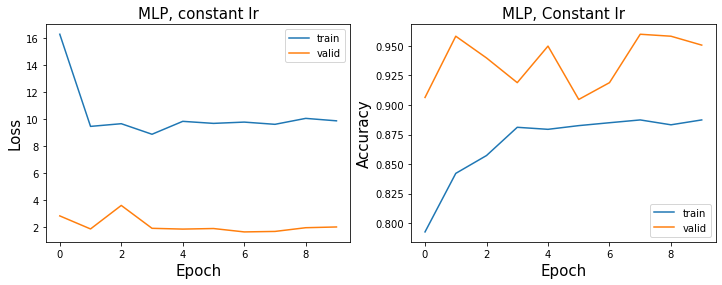

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.title("MLP, constant lr", fontsize = 15)
plt.plot(training_losses,linewidth = 1.5,label = 'train')
plt.plot(val_losses,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Loss", fontsize = 15)
plt.legend()
plt.subplot(1,2,2)
plt.title("MLP, Constant lr", fontsize = 15)
plt.plot(training_acc,linewidth = 1.5,label = 'train')
plt.plot(val_acc,linewidth = 1.5,label = 'valid')
plt.xlabel("Epoch",fontsize = 15)
plt.ylabel("Accuracy", fontsize = 15)
plt.legend()
plt.show()

In [21]:
model = MLP().to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.7, patience=3, min_lr=0.00001)


epochs = []
training_losses = []
val_losses = []
test_losses = []
training_acc = []
val_acc = []
test_acc = []

for epoch in range(30):
    lr = scheduler.optimizer.param_groups[0]['lr']
    print('Learning Rate: ' + str(lr))
    avg_train_loss, train_accuracy = train(train_loader)
    print('Train loss for epoch {}: {}'.format(epoch, avg_train_loss))
    val_loss, val_accuracy = test(val_loader)
    print('Val loss for epoch {}: {}'.format(epoch, val_loss))
    scheduler.step(val_loss)
#     test_loss, test_accuracy = test(test_loader)
    training_losses.append(avg_train_loss)
    training_acc.append(train_accuracy)
    val_losses.append(val_loss)
    val_acc.append(val_accuracy)
#     test_losses.append(test_loss)
#     test_acc.append(test_accuracy)

Learning Rate: 0.0005
Train loss for epoch 0: 20.655139923095703
Val loss for epoch 0: 15.661205291748047
Learning Rate: 0.0005
Train loss for epoch 1: 19.15169906616211
Val loss for epoch 1: 16.122947692871094
Learning Rate: 0.0005
Train loss for epoch 2: 17.522554397583008
Val loss for epoch 2: 1.2294986248016357
Learning Rate: 0.0005
Train loss for epoch 3: 14.297297477722168
Val loss for epoch 3: 1.9700162410736084
Learning Rate: 0.0005
Train loss for epoch 4: 10.056283950805664
Val loss for epoch 4: 4.8047027587890625
Learning Rate: 0.0005
Train loss for epoch 5: 9.851273536682129
Val loss for epoch 5: 3.965311050415039
Learning Rate: 0.0005
Train loss for epoch 6: 9.279043197631836
Val loss for epoch 6: 2.9345109462738037
Learning Rate: 0.00035
Train loss for epoch 7: 8.85105037689209
Val loss for epoch 7: 2.942730188369751
Learning Rate: 0.00035
Train loss for epoch 8: 9.177160263061523
Val loss for epoch 8: 3.906432628631592
Learning Rate: 0.00035
Train loss for epoch 9: 9.0415